<a href="https://colab.research.google.com/github/TheDandyCodes/Deep-Learning/blob/main/Unit_2/umich_sentiment_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM with Keras — sentiment analysis

https://learning.oreilly.com/library/view/deep-learning-with/9781787128422/cc94d70d-37d3-4bc3-9483-2f26e673f88b.xhtml

Adaptado a Python 3

In [2]:
# import the necessary packages
# Cambio a tensorflow 2.x
# En lugar de from keras import, from tensorflow.keras import
# ciertos subpaquetes del antiguo keras desaparacen o cambian de nombre
# ver lista siguiente

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")


# from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Activation, Dense, Dropout, SpatialDropout1D
# from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Embedding
# from keras.layers.recurrent import LSTM
from tensorflow.keras.layers import LSTM
# from keras.models import Sequential
from tensorflow.keras.models import Sequential
# from keras.preprocessing import sequence
from tensorflow.keras.preprocessing import sequence

from sklearn.model_selection import train_test_split

import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os

from platform import python_version

print(python_version())

3.11.11


In [6]:
#DATA_DIR = "../data"
# Si se crea un directorio para los datos indicarlo
# si se usa el mismo que el del notebook dejarlo tal cual
DATA_DIR = "./"

MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40

EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

In [9]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
# Read training data and generate vocabulary
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
# ftrain = open(os.path.join(DATA_DIR, "umich-sentiment-train.txt"), 'rb')
ftrain = open(os.path.join(DATA_DIR, "umich-sentiment-train.txt"), 'r', encoding='utf-8')
for line in ftrain:
    label, sentence = line.strip().split("\t")
    # words = nltk.word_tokenize(sentence.decode("ascii", "ignore").lower())
    words = nltk.word_tokenize(sentence.lower())
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
    num_recs += 1
ftrain.close()

## Get some information about our corpus
print(maxlen)            # 42
print(len(word_freqs))   # 2328

42
2268


In [11]:
# 1 is UNK, 0 is PAD
# We take MAX_FEATURES-1 features to account for PAD
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in
                enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}

# convert sentences to sequences
X = np.empty((num_recs, ), dtype=list)
y = np.zeros((num_recs, ))
i = 0
# ftrain = open(os.path.join(DATA_DIR, "umich-sentiment-train.txt"), 'rb')
ftrain = open(os.path.join(DATA_DIR, "umich-sentiment-train.txt"), 'r', encoding='utf-8')
for line in ftrain:
    label, sentence = line.strip().split("\t")
    # words = nltk.word_tokenize(sentence.decode("ascii", "ignore").lower())
    words = nltk.word_tokenize(sentence.lower())
    seqs = []
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    X[i] = seqs
    y[i] = int(label)
    i += 1
ftrain.close()

In [25]:
# Ejemplo de los textos del conjunto X
examples = [" ".join([index2word[x] for x in row]) for row in X[:5]]
examples

['the da vinci code book is just awesome .',
 "this was the first clive cussler i 've ever read , but even books like relic , and da vinci code were more plausible than this .",
 'i liked the da vinci code a lot .',
 'i liked the da vinci code a lot .',
 "i liked the da vinci code but it ultimatly did n't seem to hold it 's own ."]

In [ ]:
# Pad the sequences (left padded with zeros)
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

# Split input into training and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2,
                                                random_state=42)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

# Build model
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE,
                    input_length=MAX_SENTENCE_LENGTH))
# model.add(SpatialDropout1D(Dropout(0.2))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(Xtest, ytest))

(5668, 40) (1418, 40) (5668,) (1418,)
Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 8s 1ms/sample - loss: 0.2337 - accuracy: 0.8947 - val_loss: 0.0593 - val_accuracy: 0.9774
Epoch 2/10
5668/5668 [==============================] - 6s 1ms/sample - loss: 0.0253 - accuracy: 0.9921 - val_loss: 0.0371 - val_accuracy: 0.9887
Epoch 3/10
5668/5668 [==============================] - 6s 1ms/sample - loss: 0.0098 - accuracy: 0.9972 - val_loss: 0.0402 - val_accuracy: 0.9859
Epoch 4/10
5668/5668 [==============================] - 6s 1ms/sample - loss: 0.0055 - accuracy: 0.9982 - val_loss: 0.0413 - val_accuracy: 0.9901
Epoch 5/10
5668/5668 [==============================] - 6s 1ms/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0392 - val_accuracy: 0.9894
Epoch 6/10
5668/5668 [==============================] - 6s 1ms/sample - loss: 0.0044 - accuracy: 0.9993 - val_loss: 0.0738 - val_accuracy: 0.9795
Epoch 7/10
5668/5668 [================

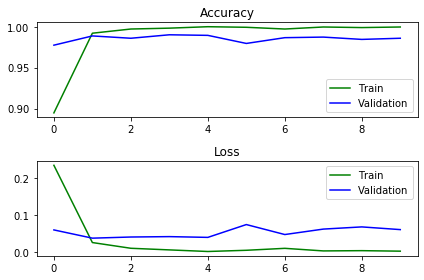

In [ ]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["accuracy"], color="g", label="Train")
plt.plot(history.history["val_accuracy"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [ ]:
# evaluate, devuelve el valor de la función de pérdida y
# de métricas para el modelo en modo test
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))

for i in range(5):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1,40)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0f\t%d\t%s" % (ypred, ylabel, sent))

1418/1418 [==============================] - 0s 246us/sample - loss: 0.0602 - accuracy: 0.9859
Test score: 0.060, accuracy: 0.986
0	0	, she helped me bobbypin my insanely cool hat to my head , and she laughed at my stupid brokeback mountain cowboy jokes..
1	1	the da vinci code was absolutely awesome !
0	0	i think i hate harry potter because it outshines much better reading material out there and the movies are just plain stupid to begin with .
0	0	then snuck into brokeback mountain , which is the most depressing movie i have ever seen..
0	0	da vinci code sucks ...


In [ ]:
# Liberar recursos GPU
# descomentar si se usa GPU

# from numba import cuda
# cuda.select_device(0)
# cuda.close()